In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

# load data

In [4]:
data_dir = 'data'

In [5]:
i_sim = 1

In [6]:
data_network = pd.read_feather('%s/network.feather'%(data_dir))
data_latent = pd.read_feather('%s/latent.feather'%data_dir)
data_feature = pd.read_feather('%s/feature_%.3d.feather'%(data_dir, i_sim))

In [7]:
data_network

,row,col
0,1,5
1,1,17
2,2,3
3,2,9
4,3,2
...,...,...
1359,397,399
1360,399,285
1361,399,329
1362,399,397


In [8]:
data_feature

,X1,X2,X3,p,T,m,Y
0,0.321514,0.653891,0.208440,0.643806,1,-2.085876,-2.114418
1,-0.104206,-1.209625,-1.308533,0.212289,0,2.932975,4.893288
2,1.219107,-0.304859,0.443877,0.663529,1,-0.684838,-2.269144
3,0.117814,-0.474473,-1.063938,0.329533,1,3.294490,1.229471
4,0.134417,-0.214230,-0.556351,0.421143,1,1.532359,1.804983
...,...,...,...,...,...,...,...
395,1.106948,0.440812,0.691159,0.753888,1,-1.618978,0.008965
396,1.137478,-0.838583,-0.174272,0.515573,1,-1.829688,-2.417781
397,-0.274102,1.099839,2.176795,0.817763,1,-3.653925,-4.175194
398,0.991127,1.094573,-0.091945,0.730444,1,-2.826090,-2.805871


In [9]:
n_node = len(data_latent); n_node

400

In [10]:
len(data_network)

1364

In [11]:
Adj = sparse.csr_matrix((
    np.full(len(data_network), True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
), shape=(n_node,n_node)).toarray()

In [12]:
G = KECENI.Graph(Adj)

In [13]:
Ys = data_feature.iloc[:,6].values
Ts = data_feature.iloc[:,4].values
Xs = data_feature.iloc[:,0:3].values

In [14]:
data = KECENI.Data(Ys, Ts, Xs, G)

# hyperparameters

In [15]:
from hyperparams import delta

# counterfactual of interest

In [16]:
i0 = 0

In [17]:
T0s_0 = np.full(n_node, 0)
T0s_1 = np.full(n_node, 1)

In [18]:
T0s_0[G.N1(i0)], T0s_1[G.N1(i0)]

(array([0, 0, 0]), array([1, 1, 1]))

In [19]:
i0s = np.array([i0])
T0s = np.array([T0s_0, T0s_1])

# groundtruth

In [20]:
from KECENI.RegressionModel import FittedRegressionModel
from KECENI.PropensityModel import FittedPropensityModel
from KECENI.CovariateModel import FittedCovariateModel

In [21]:
from true_model import mu, pi, rX

In [22]:
true_model = KECENI.Model(
    FittedRegressionModel(mu),
    FittedPropensityModel(pi),
    FittedCovariateModel(rX),
    delta
)

In [23]:
true_fit = true_model.fit(data)

In [24]:
result_true = true_fit.G_estimate(i0s, T0s, n_X=10000)

In [25]:
YTR_0, YTR_1 = result_true.reshape([2,-1])
YTR_d = YTR_1 - YTR_0

In [26]:
YTR_0, YTR_1, YTR_d

(array([-2.00697536]), array([1.99514868]), array([4.00212404]))

# estimation

In [27]:
from KECENI.RegressionModel import LinearRegressionModel
from KECENI.PropensityModel import LogisticIIDPropensityModel
from KECENI.CovariateModel import IIDCovariateModel

In [28]:
from hyperparams import summary_mu, summary_pi

In [29]:
keceni_model = KECENI.Model(
    LinearRegressionModel(summary_mu),
    LogisticIIDPropensityModel(summary_pi),
    IIDCovariateModel(bal=False),
    delta,
)

In [30]:
keceni_fit = keceni_model.fit(data, tqdm=tqdm)

fit: 100%|██████████| 400/400 [00:00<00:00, 1719.07it/s]


## - cross-validation

In [31]:
lamdas = np.linspace(0, 20, 21)[1:]

In [32]:
result_cv = keceni_fit.cv(
    tqdm=tqdm
)

cv: 100%|██████████| 400/400 [00:01<00:00, 279.95it/s]


In [33]:
xs_cv, xhs_cv = result_cv.xs_xhs(lamdas)

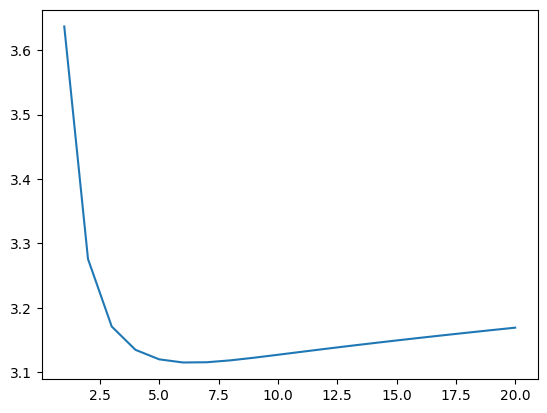

In [34]:
plt.plot(lamdas, np.mean((xs_cv-xhs_cv)**2, -1))

In [35]:
id_cv = np.argmin(np.mean((xs_cv-xhs_cv)**2, -1))
id_cv

5

In [36]:
# id_cv = 10

In [37]:
lamdas[id_cv]

6.0

## - G estimate

In [38]:
result_G = keceni_fit.G_estimate(i0s, T0s, n_X=1000)

In [39]:
YG_0, YG_1 = np.moveaxis(result_G, -1, 0)
YG_d = YG_1 - YG_0

In [40]:
YG_0, YG_1, YG_d

(-1.9532889474321127, 2.175220873814876, 4.128509821246989)

## - KECENI

In [41]:
result_AIPW = keceni_fit.kernel_AIPW(
    i0s, T0s, tqdm=tqdm
)

AIPW: 100%|██████████| 400/400 [00:00<00:00, 2504.24it/s]


In [42]:
YDR_0, YDR_1 = np.moveaxis(result_AIPW.est(lamdas), -1, 0)
YDR_d = YDR_1 - YDR_0

In [43]:
YDR_0[id_cv], YDR_1[id_cv], YDR_d[id_cv]

(-1.6793650340189097, 1.9234095207785142, 3.602774554797424)